In [1]:
#SEZIONE DI IMPORT

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfftn, fftfreq, rfftfreq
import Corrfunc
import camb 
from mcfit import P2xi

In [2]:
#FUNZIONE DI CALCOLO DEL POWER SPECTRUM P(k) USANDO LA FFT

def calculate_power_spectrum_fft(positions, box_size, n_cells=64):
    """Calcola P(k) dal campo di densità usando la FFT."""
    print("... calcolo P(k) con FFT...")

    #Calcolo la densità media
    n_points = len(positions)
    density = n_points / box_size**3
    
    #Creazione del campo di densità usando histogramdd che divide il box in celle e conta il numero di punti
    grid, edges = np.histogramdd(positions, bins=(n_cells, n_cells, n_cells), range=((0, box_size), (0, box_size), (0, box_size)))
    cell_mean_density = n_points / n_cells**3
    density_field = (grid - cell_mean_density) / cell_mean_density
    
    #Faccio la FFT del campo di densità e calcolo il Power Spectrum
    delta_k = rfftn(density_field) / n_cells**3
    pk_grid = np.abs(delta_k)**2 * (box_size**3)
    
    #Calcolo ila frequenza fondamentale
    kF = 2 * np.pi / box_size

    #Creo i vettori d'onda nelle 3 dimensioni
    kx = fftfreq(n_cells) * n_cells * kF
    ky = fftfreq(n_cells) * n_cells * kF
    kz = rfftfreq(n_cells) * n_cells * kF

    #Creo le griglie che rappresentano tutte le possibili combinazioni dei vettori d’onda nelle tre direzioni
    KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')
    KK = np.sqrt(KX**2 + KY**2 + KZ**2)
    
    #Faccio il binning del Power Spectrum
    #Creo i bordi partendo da kF fino a pi*n_cells/box_size con passo kF
    k_edges = np.arange(kF, np.pi * n_cells / box_size, kF)
    #Calcolo il centro di ogni bin
    k_bins = 0.5 * (k_edges[1:] + k_edges[:-1])
    #Sommo i valori del power spectrum per tutti i punti che cadono nello stesso bin di k
    pk_average, _ = np.histogram(KK.flatten(), bins=k_edges, weights=pk_grid.flatten())
    #Conta quanti valori cadono in ogni bin di k
    counts, _ = np.histogram(KK.flatten(), bins=k_edges)
    
    #Normalizzo il Power Spectrum e correggo il short noise dovuto alla discretizzazione
    pk_average = np.divide(pk_average, counts, out=np.full_like(pk_average, np.nan), where=counts!=0)
    pk_corrected = pk_average - (1.0 / density)
    
    return k_bins, pk_corrected



In [ ]:
#FUNZIONE DI CALCOLO DELLA FUNZIONE DI CORRELAZIONE XI(R) USANDO CORRFUNC E IL METODO LANDY-SZALAY

def calculate_correlation_function(positions, box_size, n_random_factor=5, n_threads=4):
    n_data = len(positions)
    
    print(f"... calcolo xi(r) per {n_data} punti...")
    #Converto positions in un array NumPy a 64 bit 
    positions = np.asarray(positions, dtype=np.float64)

    # Crea catalogo casuale con punti multipli di quelli reali
    n_random = n_data * n_random_factor
    random_positions = np.random.uniform(0, box_size, size=(n_random, 3))

    # Definisco i bin tra 0 e 2.3 con scala logaritmica
    r_bins = np.logspace(0, 2.3, 50)
    # Calcolo il centro dei bin
    r_centers = 0.5 * (r_bins[:-1] + r_bins[1:]) 

    # Calcolo DD (Data-Data pairs)(stesso catalogo)
    dd_res = Corrfunc.theory.DD(autocorr=True, nthreads=n_threads, binfile=r_bins,
                               X1=positions[:, 0], Y1=positions[:, 1], Z1=positions[:, 2],
                               boxsize=box_size, periodic=True)

    # Calcolo DR (Data-Random pairs)(catalogo diverso)
    dr_res = Corrfunc.theory.DD(autocorr=False, nthreads=n_threads, binfile=r_bins,
                               X1=positions[:, 0], Y1=positions[:, 1], Z1=positions[:, 2],
                               X2=random_positions[:, 0], Y2=random_positions[:, 1], Z2=random_positions[:, 2],
                               boxsize=box_size, periodic=True)

    # Calcolo RR (Random-Random pairs)(stesso catalogo)
    rr_res = Corrfunc.theory.DD(autocorr=True, nthreads=n_threads, binfile=r_bins,
                               X1=random_positions[:, 0], Y1=random_positions[:, 1], Z1=random_positions[:, 2],
                               boxsize=box_size, periodic=True)

    # Estraggo conteggi
    DD = dd_res['npairs']
    DR = dr_res['npairs']
    RR = rr_res['npairs']

    # Fattori di normalizzazione
    norm_dd = n_data * n_data
    norm_dr = n_data * n_random
    norm_rr = n_random * n_random

    # Formula di Landy-Szalay per calcolare xi(r)
    with np.errstate(invalid='ignore', divide='ignore'):
        xi = ( (DD / norm_dd) - 2 * (DR / norm_dr) + (RR / norm_rr) ) / (RR / norm_rr)
    #Eventuali valori NaN vengono sostituiti con 0.0
    xi[np.isnan(xi)] = 0.0 

    return r_centers, xi



In [4]:
#FUNZIONE PER CALCOLARE P(k) TEORICO CON CAMB

def get_theoretical_pk_camb(cosmo_params, redshift):

    print(f"... calcolo P(k) teorico con CAMB per z={redshift}...")
    
    # Lista dei redshift da calcolare: z=0 e il redshift target (se diverso)
    target_redshift = float(redshift)
    redshifts_to_calc = [0.0]
    if not np.isclose(target_redshift, 0.0):
        redshifts_to_calc.append(target_redshift)
    

    #Setto la cosmologia in CAMB
    camb_params = camb.CAMBparams()
    camb_params.set_cosmology(
        H0=cosmo_params['H0'], 
        ombh2=cosmo_params['ombh2'], 
        omch2=cosmo_params['omch2'],
        mnu=cosmo_params['mnu'],
        num_massive_neutrinos=cosmo_params['num_massive_neutrinos']
    )
    camb_params.InitPower.set_params(ns=cosmo_params['ns'])

    # Imposto CAMB per calcolare P(k) a tutti i redshift nella lista fino a kmax=10.0
    camb_params.set_matter_power(redshifts=sorted(list(set(redshifts_to_calc))), kmax=10.0)    
    camb_results = camb.get_results(camb_params)

    #Rinormalizzo a sigma8 calcolato per z=0
    sigma8_z0_camb = camb_results.get_sigma8_0()
    renorm_factor = (cosmo_params['sigma8_target'] / sigma8_z0_camb)**2  

    #Estraggo i valori di k, redshift e P(k) teorici calcolati da CAMB
    k_theory, z_array, pk_theory_raw = camb_results.get_matter_power_spectrum(minkh=1e-4, maxkh=10.0, npoints=200)
    
    #Seleziono il P(k) al redshift di target e lo rinormalizzo
    pk_for_target_z = camb_results.get_matter_power_interpolator().P(z_array, k_theory)[-1]
    pk_theory_renorm = pk_for_target_z * renorm_factor
    
    return k_theory, pk_theory_renorm

In [5]:
#FUNZIONE PER CALCOLARE xi(r) TEORICO DA P(k) 

#Utilizza la libreria 'mcfit' per la trasformata di Fourier
def get_theoretical_xi_from_pk(k, pk, bias):
    if P2xi is None: return None, None
    print("... calcolo xi(r) teorica da P(k)...")

    # Applica il bias al P(k) della materia
    pk_biased = pk * (bias**2)
    
    # Esegui la trasformata di Fourier per ottenere xi(r)
    r, xi = P2xi(k)(pk_biased)
    return r, xi

In [6]:
# PARAMETRI GLOBALI E LISTE DEI FILE DI DATI

#Dimensione del box di Magneticum presa dalla documentazione
L = 640.0

#Lista dei file di dati da analizzare
file_list = [
    "galaxy025.txt",
    "galaxy042.txt",
    "galaxy067.txt",
    "galaxy117.txt",
    "galaxy198.txt"
]

#Lista dei bias per ogni redshift per il taglio di massa più blando
bias_by_file = {
    "galaxy025.txt": 1.83,
    "galaxy042.txt": 1.9,
    "galaxy067.txt": 2.23,
    "galaxy117.txt": 2.81,
    "galaxy198.txt": 3.78,
}


In [7]:
#DEFINIZIONE DEI TAGLI DI MASSA E SFR PER OGNI REDSHIFT SELEZIONATI IN MODO DA AVERE UN NUMERO SUFFICIENTE DI PUNTI PER CALCOLARE P(k) E xi(r) (>30000 PUNTI)

#Tagli in massa in modo da avere un numero sufficiente di punti per calcolare P(k) e xi(r) (>30000 punti)
mass_cuts_by_redshift = {
    "Massa > soglia A": {
        "galaxy025.txt": 1.5e11,
        "galaxy042.txt": 1e11,
        "galaxy067.txt": 1.6e11,
        "galaxy117.txt": 1.6e11,
        "galaxy198.txt": 1.5e11,
    },
    "Massa > soglia B": {
        "galaxy025.txt": 1.75e11,
        "galaxy042.txt": 1.25e11,
        "galaxy067.txt": 1.8e11,
        "galaxy117.txt": 1.8e11,
        "galaxy198.txt": 1.75e11,
    },
    "Massa > soglia C": {
        "galaxy025.txt": 2e11,
        "galaxy042.txt": 1.5e11,
        "galaxy067.txt": 2.1e11,
        "galaxy117.txt": 2.1e11,
        "galaxy198.txt": 2e11,
    }
}

#Tagli in tasso di formazione stellare (SFR) in modo da avere un numero sufficiente di punti per calcolare P(k) e xi(r) (>30000 punti)
sfr_cuts_by_redshift = {
    "log(sfr) > soglia A": {
        "galaxy025.txt": 1.40,
        "galaxy042.txt": 1.75,
        "galaxy067.txt": 0.9,
        "galaxy117.txt": 1,
        "galaxy198.txt": 1.15,
    },
    "log(sfr) > soglia B": {
        "galaxy025.txt": 1.45,
        "galaxy042.txt": 1.85,
        "galaxy067.txt": 1.00,
        "galaxy117.txt": 1.05,
        "galaxy198.txt": 1.22,
    },
    "log(sfr) > soglia C": {
        "galaxy025.txt": 1.5,
        "galaxy042.txt": 1.95,
        "galaxy067.txt": 1.10,
        "galaxy117.txt": 1.10,
        "galaxy198.txt": 1.30
    }
}



In [8]:
#PIANO DI ANALISI DA SEGUIRE PER OGNI FILE DI DATI

analysis_plan = [
    {
        "analysis_name": "Tasso di Formazione Stellare (SFR)",
        "cuts_dict": sfr_cuts_by_redshift,
        "column_index": 8,  # Colonna 9 del file: sfr[Msol/year]
        "cut_logic": 'log_gt' 
    },

    {
        "analysis_name": "Massa",
        "cuts_dict": mass_cuts_by_redshift,
        "column_index": 7,  # Colonna 8 del file: m[Msol/h]
        "cut_logic": 'gt'
    }
]


In [9]:
#DEFINIZIONE DEI PARAMETRI COSMOLOGICI

COSMOLOGY_PARAMS = {
    'H0': 70.4,                  # Costante di Hubble in km/s/Mpc
    'ombh2': 0.022,              # Densità fisica barionica
    'omch2': 0.112,              # Densità fisica materia oscura fredda (om_matter * h^2 - ombh2)
    'mnu': 0,                    # Massa totale dei neutrini in eV
    'num_massive_neutrinos': 0,  # Numero di neutrini massivi
    'ns': 0.963,                 # Indice spettrale primordiale
    'sigma8_target': 0.809       # Valore di sigma8 a cui normalizzare
}

In [10]:
#CICLO PRINCIPALE PER L'ANALISI DEI FILE

#Creo un dizionario per memorizzare i risultati
results = {}
np.seterr(divide='ignore', invalid='ignore')

#Per ogni file crea una chiave nel dizionario dei risultati
for filename in file_list:
    print(f"\nProcessing file: {filename}...")
    results[filename] = {}
    try:
        
        # Estraggo il redshift dal nome del file
        redshift_str = ''.join(filter(str.isdigit, filename.split('.')[0]))
        redshift = float(redshift_str) / 100.0 if redshift_str else 0.0

        #Calcolo P(k) teorico
        k_theory, pk_theory = get_theoretical_pk_camb(COSMOLOGY_PARAMS, redshift)
        if k_theory is not None:
            results[filename]['theoretical_pk'] = {'k': k_theory, 'pk': pk_theory}
            
            # Calcolo xi(r) teorico da P(k) teorico usando il bias specifico per il file oppure 2.0 di default
            bias_val = bias_by_file.get(filename, 2.0)
            r_theory, xi_theory = get_theoretical_xi_from_pk(k_theory, pk_theory, bias_val)
            if r_theory is not None:
                #Salvo entrambi nel dizionario dei risultati
                results[filename]['theoretical_xi'] = {'r': r_theory, 'xi': xi_theory}
    except (ValueError, IndexError):
        print(f"ATTENZIONE: Impossibile estrarre il redshift dal nome file '{filename}'.")
        continue

    #Per ogni piano di analisi prende la colonna e i tagli associati
    for analysis in analysis_plan:
        analysis_name = analysis["analysis_name"]
        cuts_dict = analysis["cuts_dict"]
        col_idx = analysis["column_index"]
        cut_logic = analysis["cut_logic"]

        print(f"\n====== INIZIO ANALISI: {analysis_name} ======")
        results[filename][analysis_name] = {}
        full_data = np.loadtxt(filename, usecols=(1, 2, 3, col_idx)) 
        
        #Estraggo da full_data le posizioni e i dati per il taglio
        positions_full = full_data[:, 0:3] / 1000.0
        data_for_cut = full_data[:, 3]

        for label, thresholds_by_file in cuts_dict.items():
            
            #Per ogni taglio, prendo il valore specifico per il file corrente
            threshold = thresholds_by_file[filename]
            
            plot_label = f"{label} ({threshold})"
            print(f"\n--- Applico taglio: {plot_label} ---")
            
            #Definisco la maschera per il taglio in base alla logica specificata (gt maggiore, lt minore, log_gt logaritmo maggiore)
            if cut_logic == 'gt':
                mask = data_for_cut > threshold
            elif cut_logic == 'lt':
                mask = data_for_cut < threshold
            elif cut_logic == 'log_gt':
                valid_data_mask = data_for_cut > 0
                mask = np.full(data_for_cut.shape, False, dtype=bool)
                if np.any(valid_data_mask):
                    log_data = np.log10(data_for_cut[valid_data_mask])
                    mask[valid_data_mask] = log_data > threshold
            else:
                print(f"ERRORE: Logica di taglio '{cut_logic}' non riconosciuta. Salto.")
                continue

            #Applico la maschera per ottenere il sotto-campione
            subsample_positions = positions_full[mask]
            print(f"Numero di oggetti nel sotto-campione: {len(subsample_positions)}")

            #Calcolo P(k) e xi(r) per il sotto-campione
            k, pk = calculate_power_spectrum_fft(subsample_positions, L)
            r, xi = calculate_correlation_function(subsample_positions, L)
            
            #Salvo i risultati nel dizionario con una chiave per il taglio applicato
            results[filename][analysis_name][plot_label] = {'k': k, 'pk': pk, 'r': r, 'xi': xi}

print("\n\nCalcolo completato per tutte le analisi.")


Processing file: galaxy025.txt...
... calcolo P(k) teorico con CAMB per z=0.25...
Note: redshifts have been re-sorted (earliest first)
... calcolo xi(r) teorica da P(k)...

====== INIZIO ANALISI: Tasso di Formazione Stellare (SFR) ======

--- Applico taglio: log(sfr) > soglia A (1.4) ---
Numero di oggetti nel sotto-campione: 120097
... calcolo P(k) con FFT...
... calcolo xi(r) per 120097 punti...

--- Applico taglio: log(sfr) > soglia B (1.45) ---
Numero di oggetti nel sotto-campione: 88668
... calcolo P(k) con FFT...
... calcolo xi(r) per 88668 punti...

--- Applico taglio: log(sfr) > soglia C (1.5) ---
Numero di oggetti nel sotto-campione: 64761
... calcolo P(k) con FFT...
... calcolo xi(r) per 64761 punti...

====== INIZIO ANALISI: Massa ======

--- Applico taglio: Massa > soglia A (150000000000.0) ---
Numero di oggetti nel sotto-campione: 86679
... calcolo P(k) con FFT...
... calcolo xi(r) per 86679 punti...

--- Applico taglio: Massa > soglia B (175000000000.0) ---
Numero di ogge

In [12]:
#CALCOLO DEL VALORE DEL BIAS PER OGNI FILE E ANALISI

#Importo pandas per creare la tabella dei risultati
import pandas as pd  

#Creo una lista per salvare i risultati del bias
bias_results = []

# Calcolo del bias e creazione di una tabella

#Faccio un ciclo su tutti i file di input
for filename, file_results in results.items():

    # Estraggo il redshift dal nome del file e lo converto in float
    redshift_str = ''.join(filter(str.isdigit, filename.split('.')[0]))
    redshift = float(redshift_str) / 100.0 if redshift_str else 0.0
    
    # Recupero i dati teorici
    theoretical_data = file_results.get('theoretical_pk', None)
    k_theory, pk_theory = theoretical_data['k'], theoretical_data['pk']
    
    #Faccio un ciclo su ogni analisi per questo file
    for analysis_name, analysis_results in file_results.items():
        if not isinstance(analysis_results, dict):
            continue
        
        #Faccio un ciclo sui risultati dell'analisi corrente saltando le voci che non sono dizionari
        for label, data in analysis_results.items():
            if not isinstance(data, dict):
                continue
            # Prendo i k e i pk osservati
            if data.get('k') is not None and data.get('pk') is not None:
                k_obs, pk_obs = data['k'], data['pk']

                # Interpolo P(k) teorico sui k osservati
                pk_theory_interp = np.interp(k_obs, k_theory, pk_theory, left=np.nan, right=np.nan)

                # Calcola il bias per ogni bin di k facendo il rapporto
                with np.errstate(invalid='ignore', divide='ignore'):
                    bias_values = np.sqrt(pk_obs / pk_theory_interp)
                bias_values = bias_values[np.isfinite(bias_values)]  # Rimuovi valori NaN o infiniti

                # Calcolo il bias medio
                mean_bias = np.mean(bias_values)  

                # Salva i risultati
                bias_results.append({
                    'File': filename,
                    'Redshift': redshift,
                    'Analysis': analysis_name,
                    'Cut': label,
                    'Bias': mean_bias
                })
# Crea una tabella con i risultati
bias_table = pd.DataFrame(bias_results)

# Salva la tabella in un file CSV
#bias_table.to_csv('/Users/pietromongiardini/Astrocompu/bias_results.csv', index=False)

# Mostra la tabella
print(bias_table)


# Paper di rifemento teoria bias: 1611.09787

             File  Redshift                            Analysis  \
0   galaxy025.txt      0.25  Tasso di Formazione Stellare (SFR)   
1   galaxy025.txt      0.25  Tasso di Formazione Stellare (SFR)   
2   galaxy025.txt      0.25  Tasso di Formazione Stellare (SFR)   
3   galaxy025.txt      0.25                               Massa   
4   galaxy025.txt      0.25                               Massa   
5   galaxy025.txt      0.25                               Massa   
6   galaxy042.txt      0.42  Tasso di Formazione Stellare (SFR)   
7   galaxy042.txt      0.42  Tasso di Formazione Stellare (SFR)   
8   galaxy042.txt      0.42  Tasso di Formazione Stellare (SFR)   
9   galaxy042.txt      0.42                               Massa   
10  galaxy042.txt      0.42                               Massa   
11  galaxy042.txt      0.42                               Massa   
12  galaxy067.txt      0.67  Tasso di Formazione Stellare (SFR)   
13  galaxy067.txt      0.67  Tasso di Formazione Stellare (SFR

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

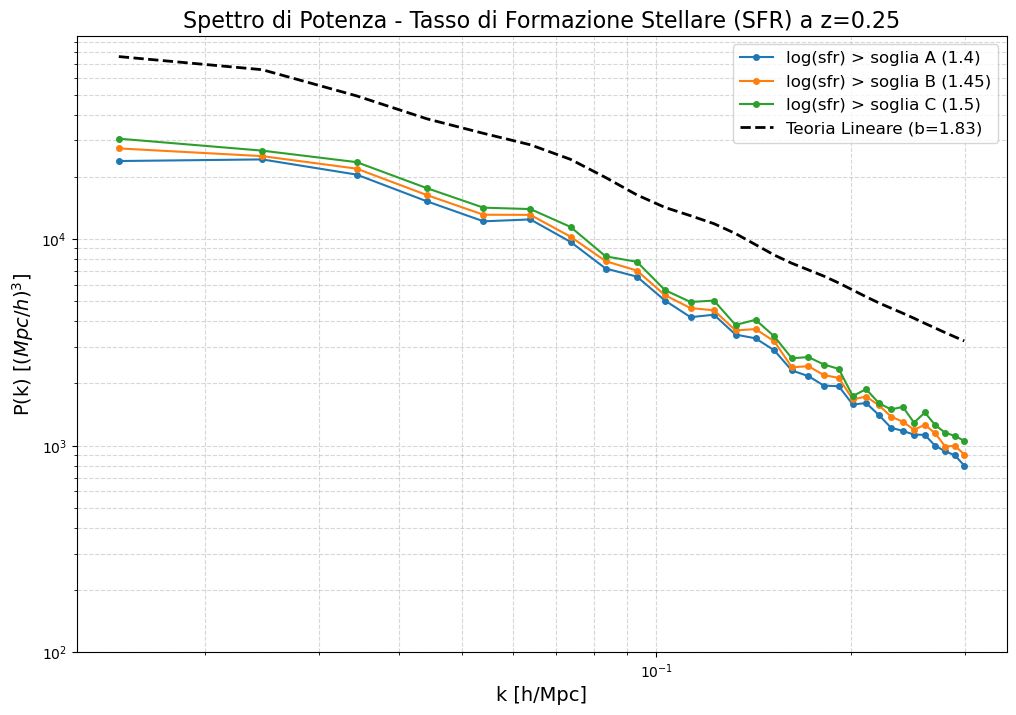

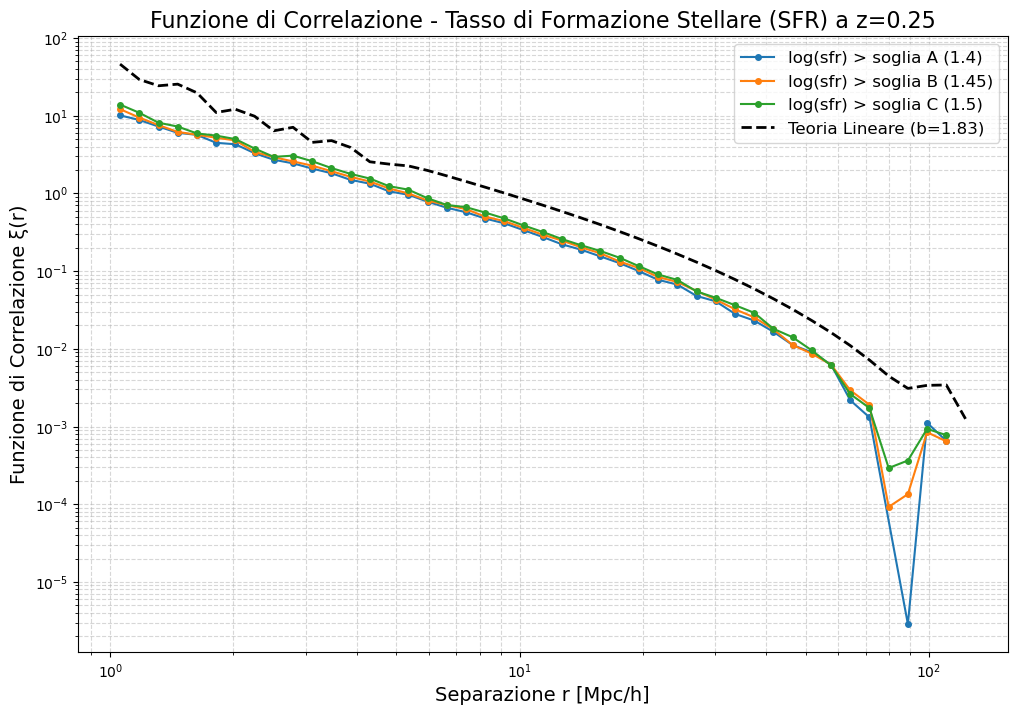

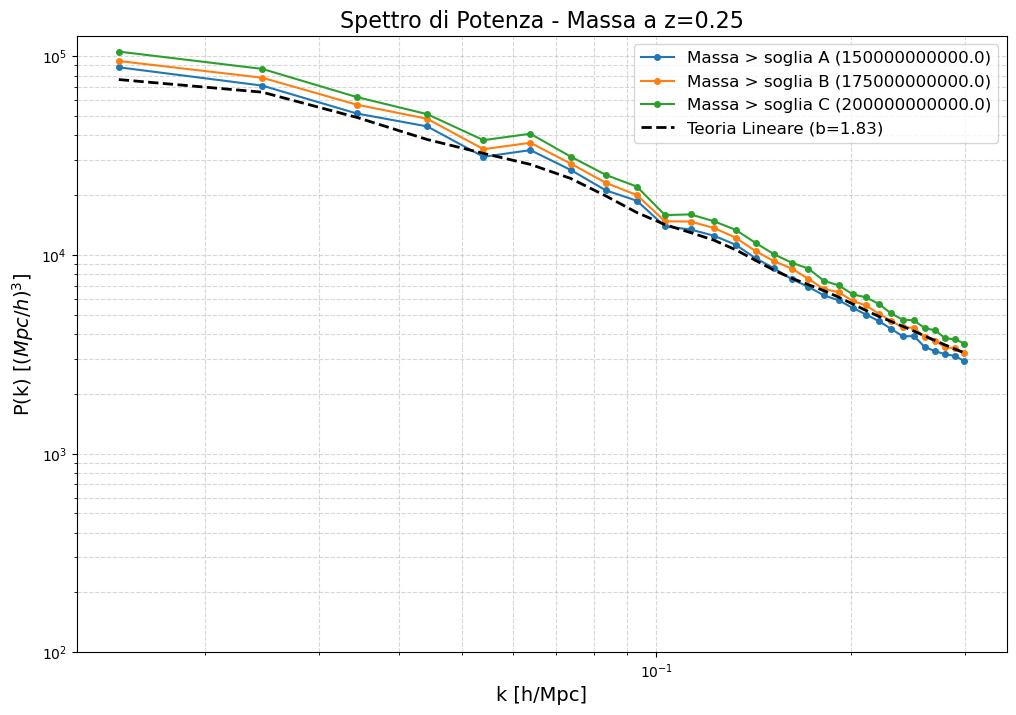

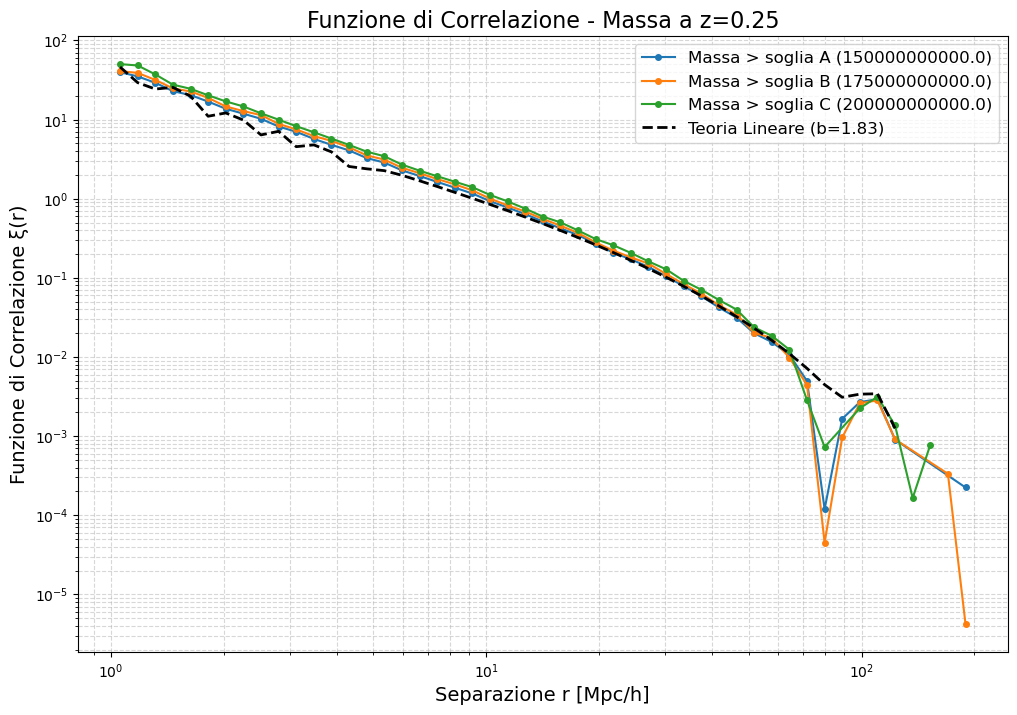

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

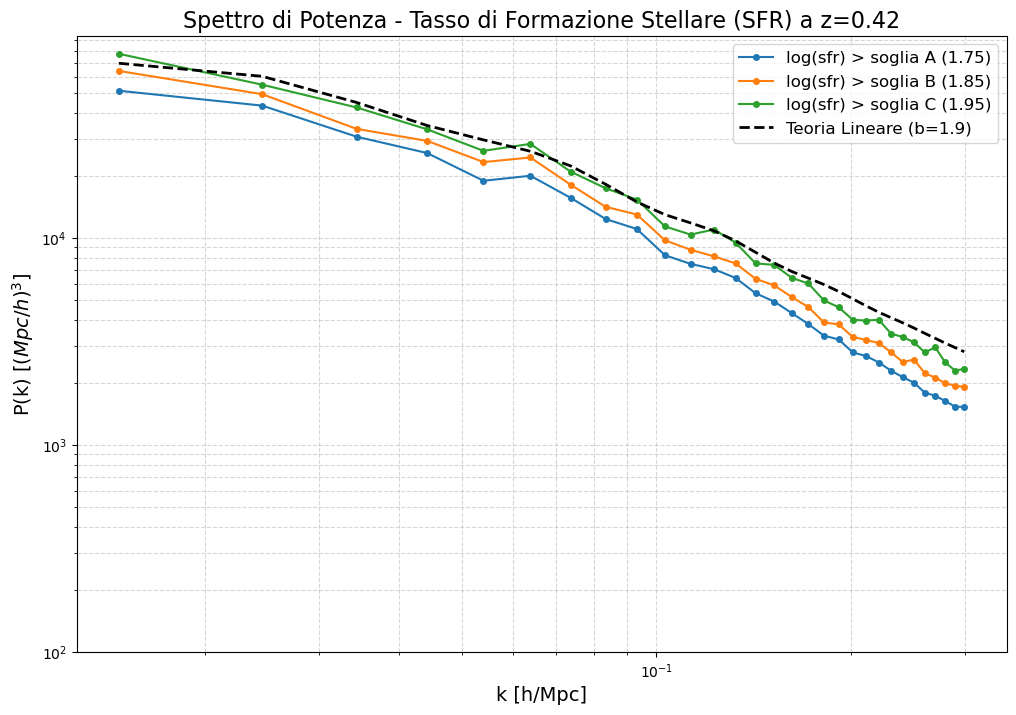

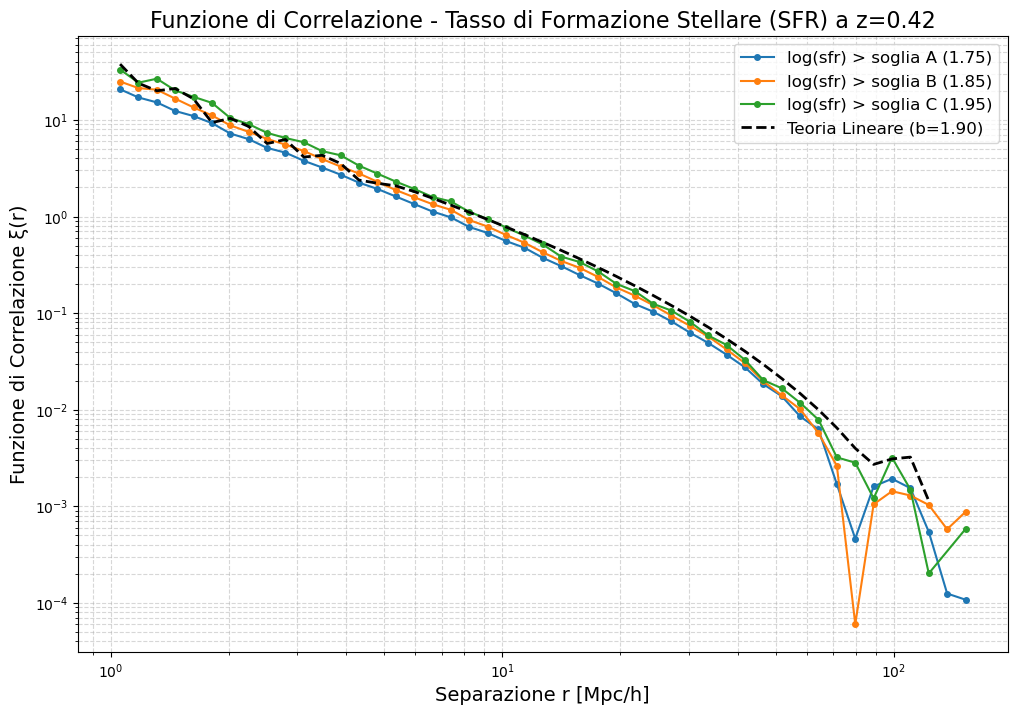

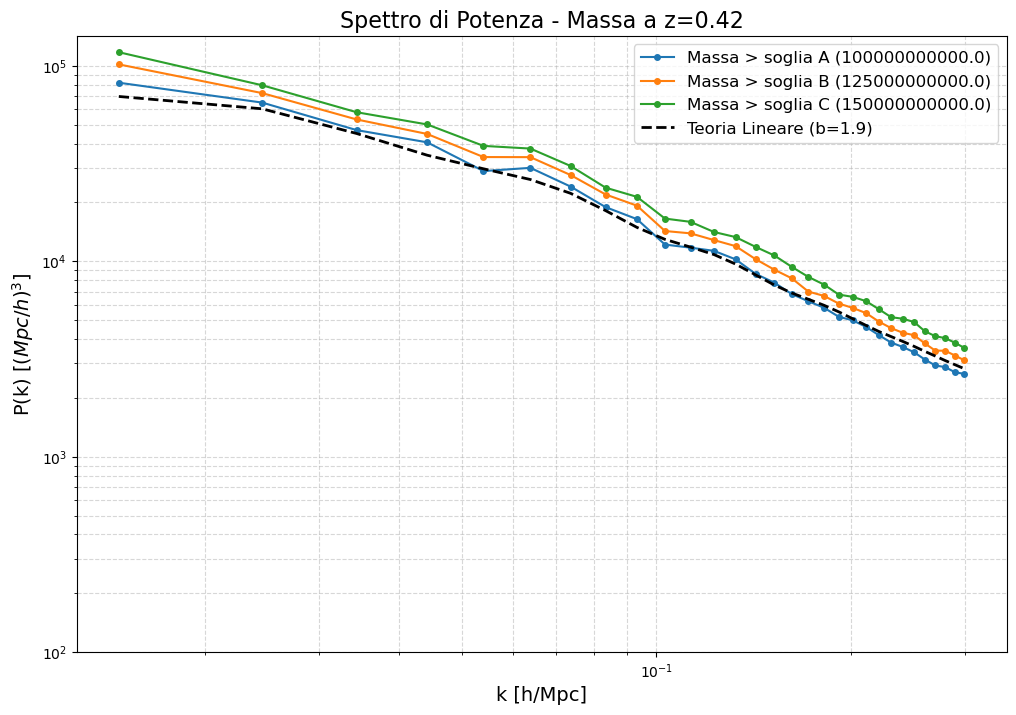

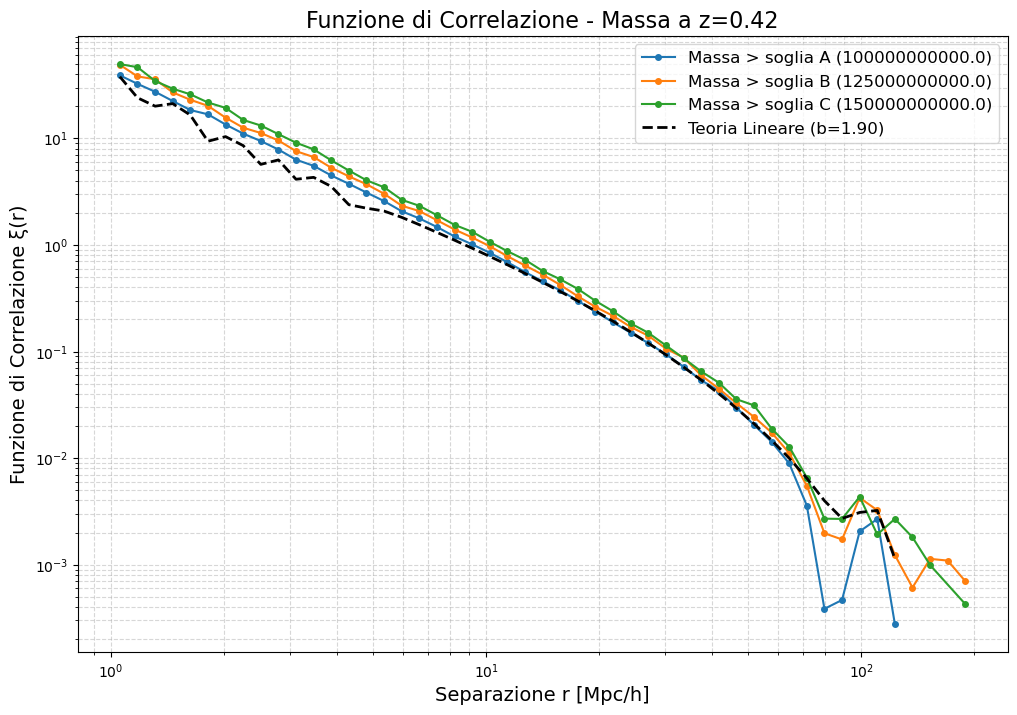

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

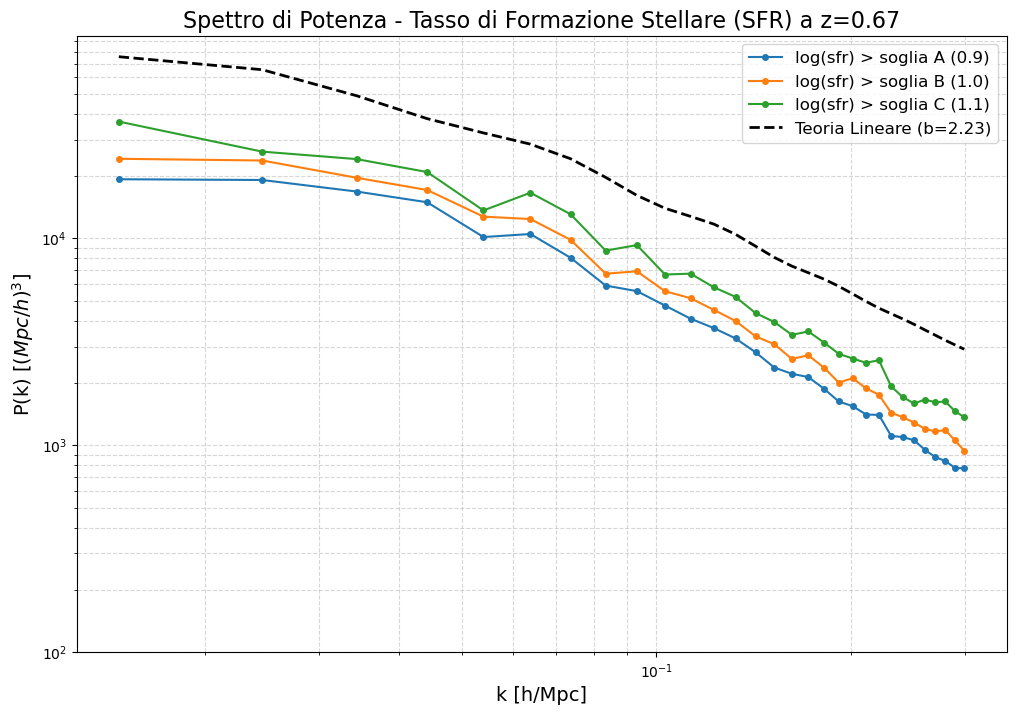

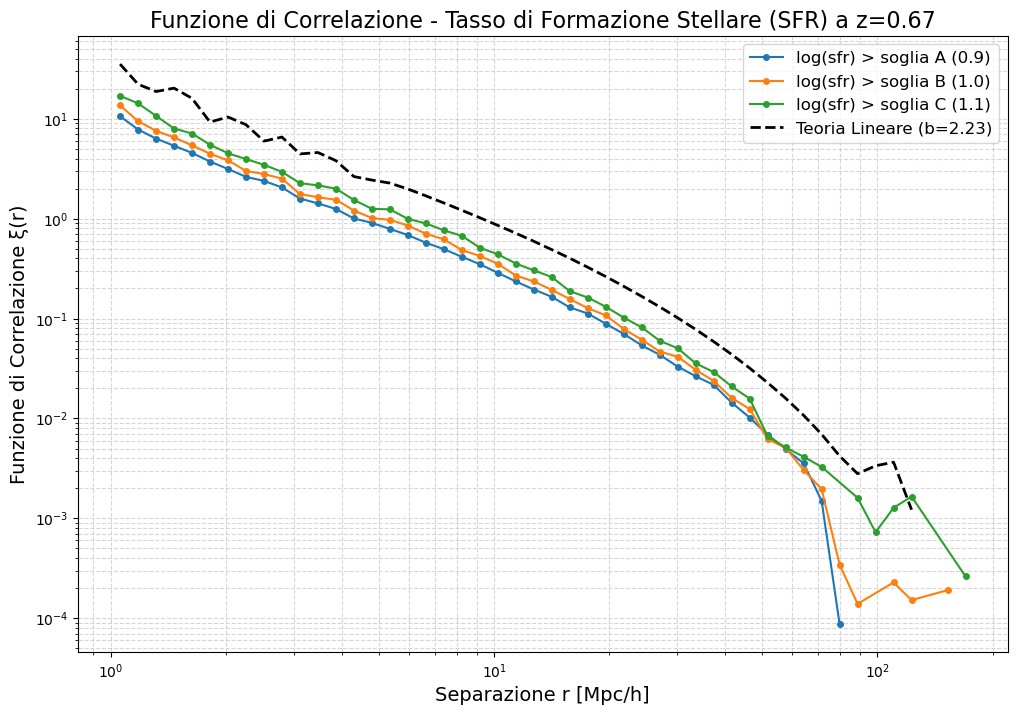

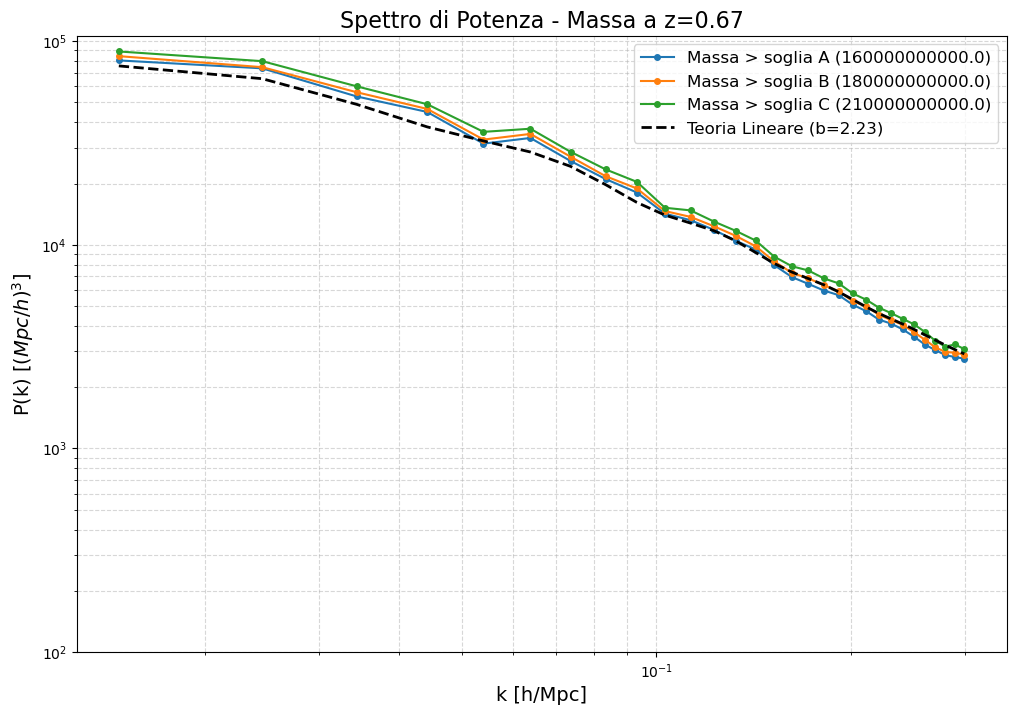

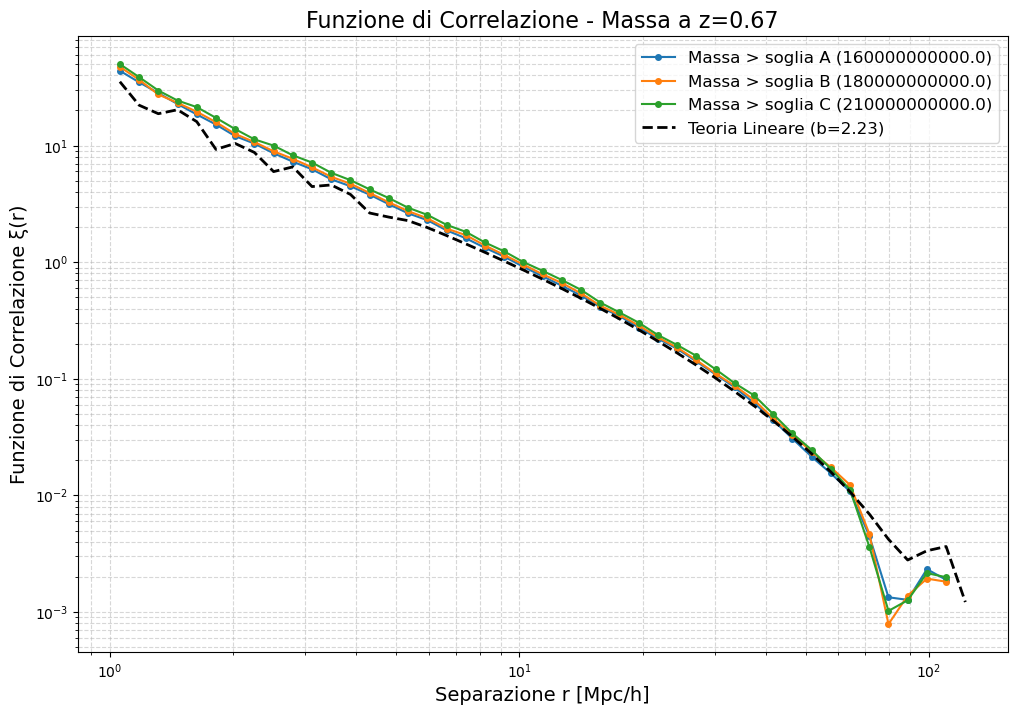

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

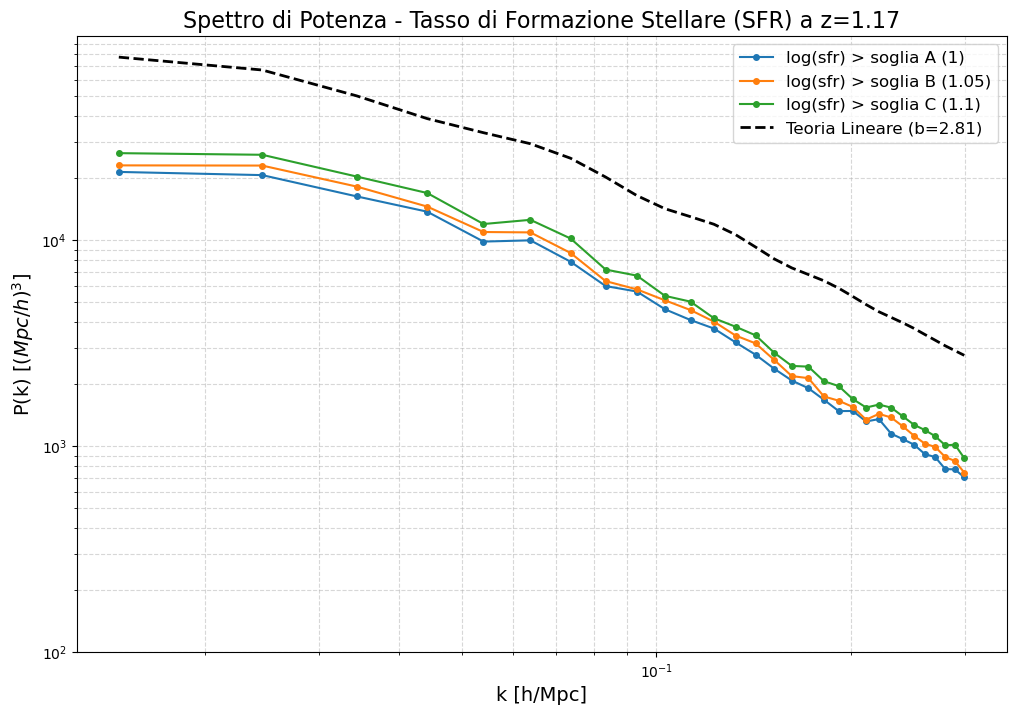

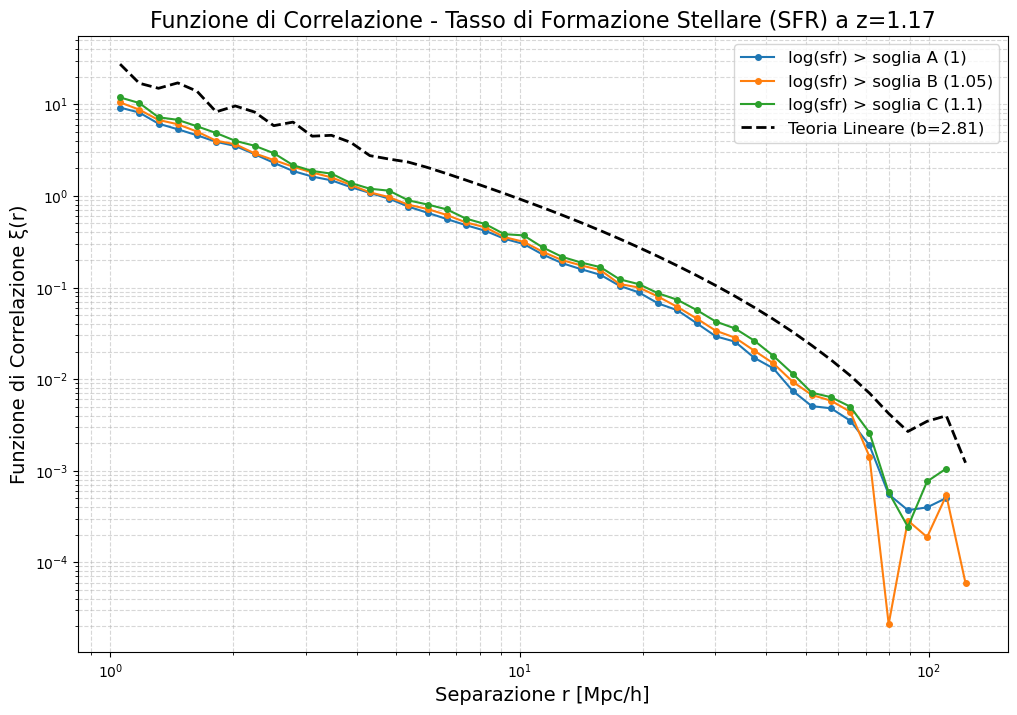

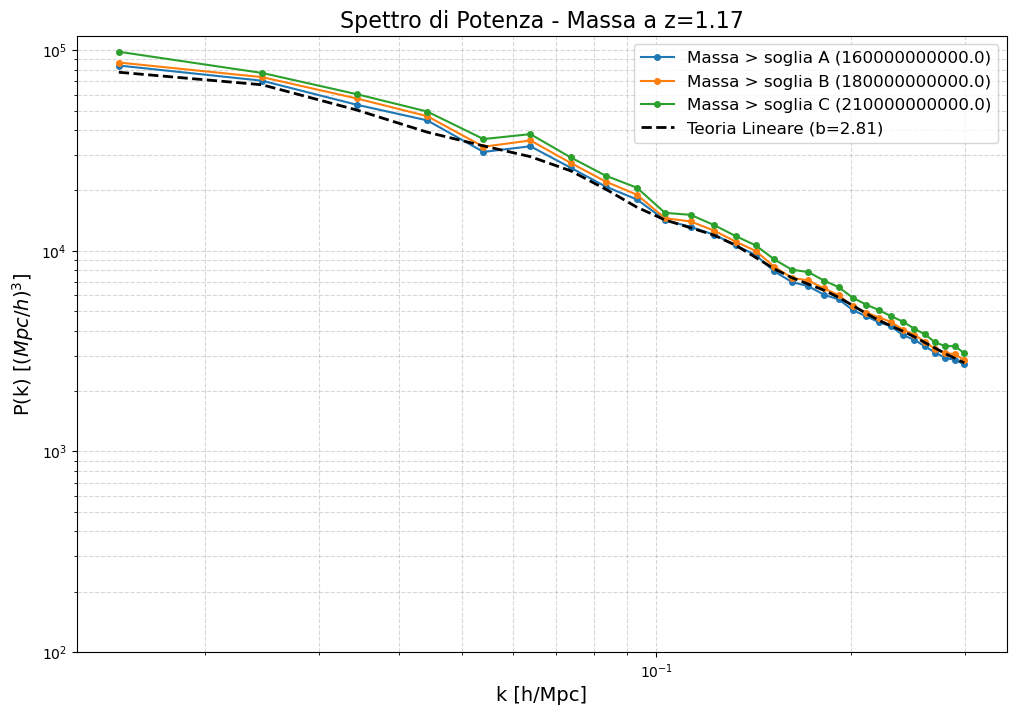

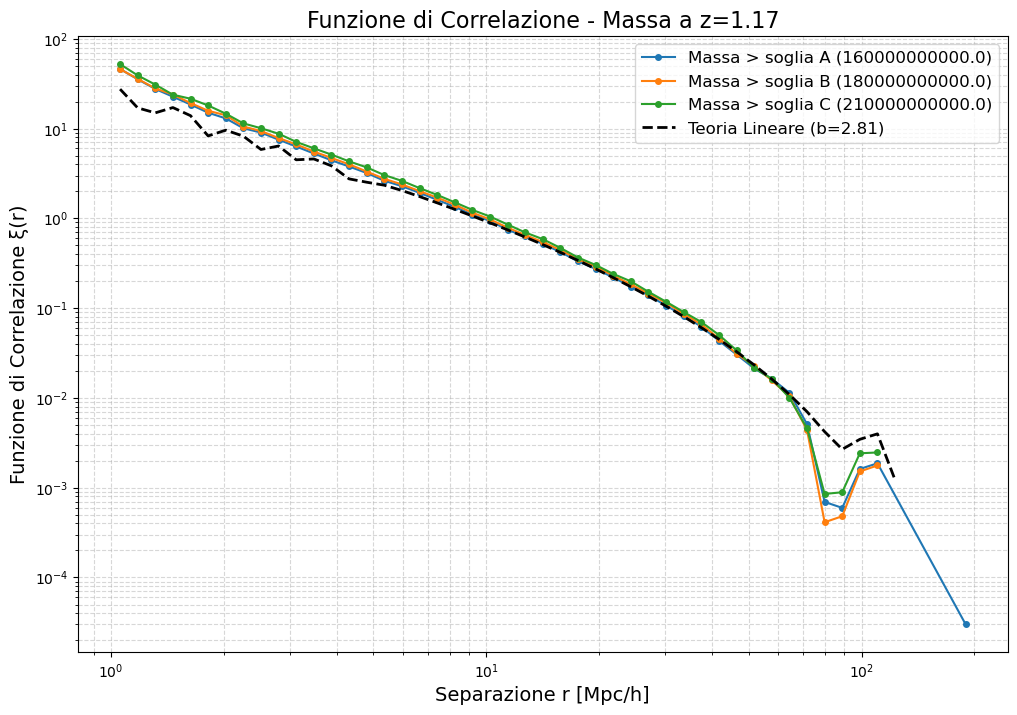

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

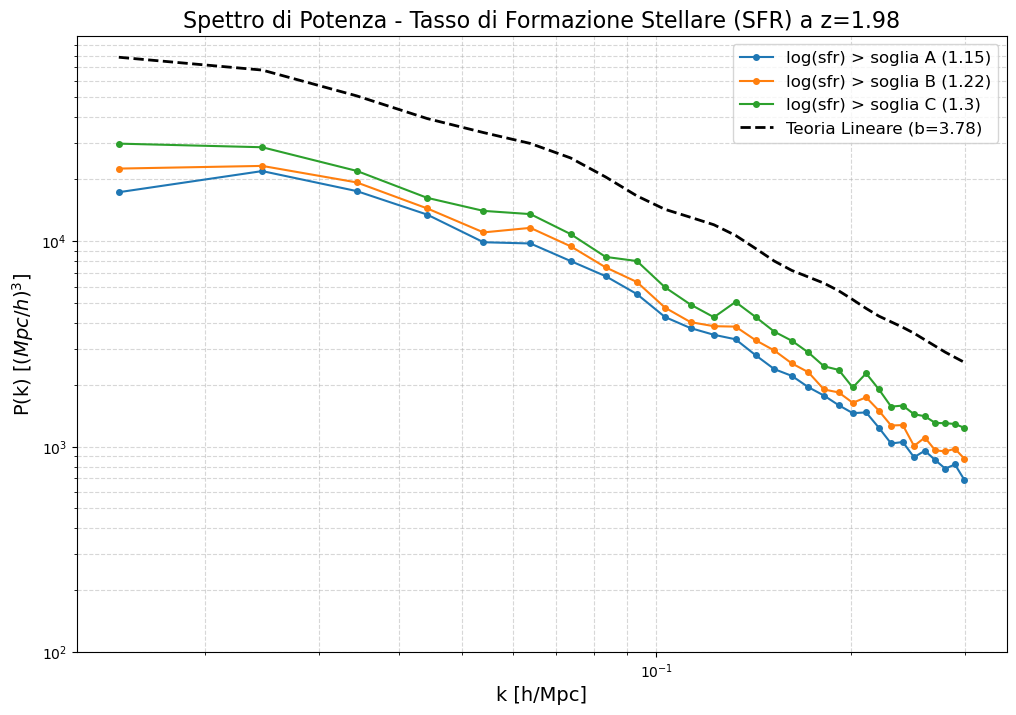

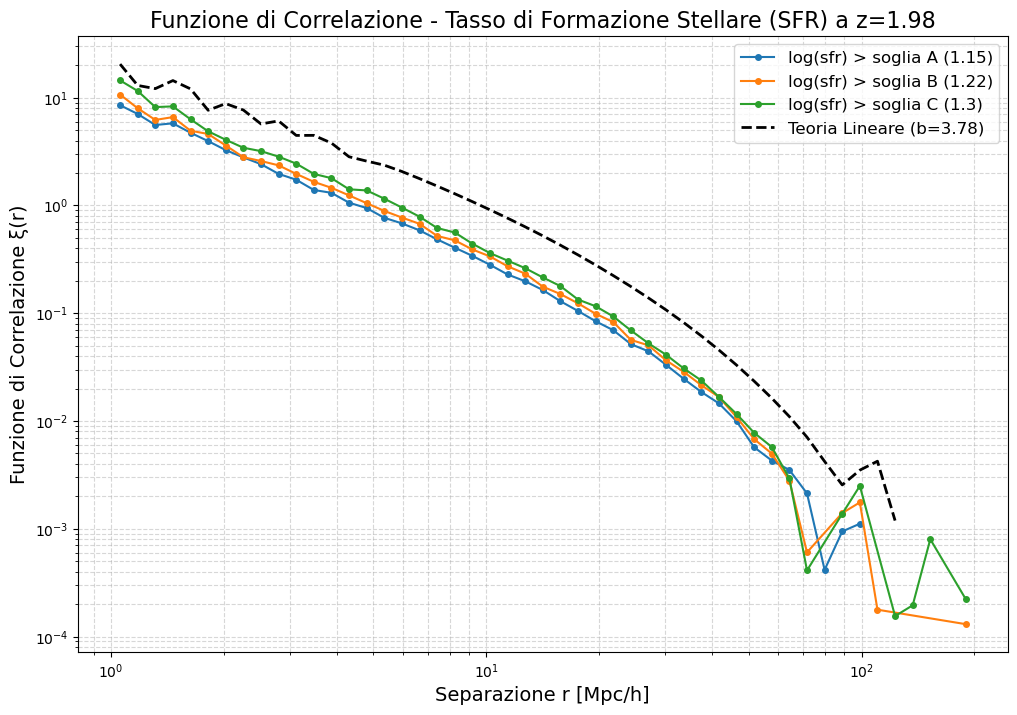

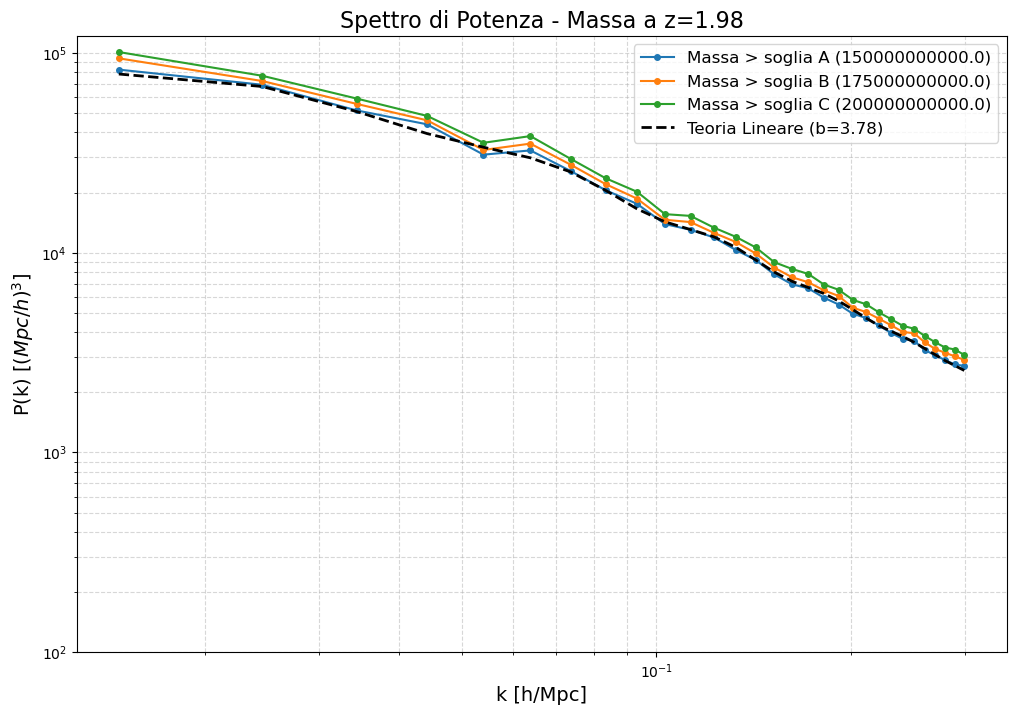

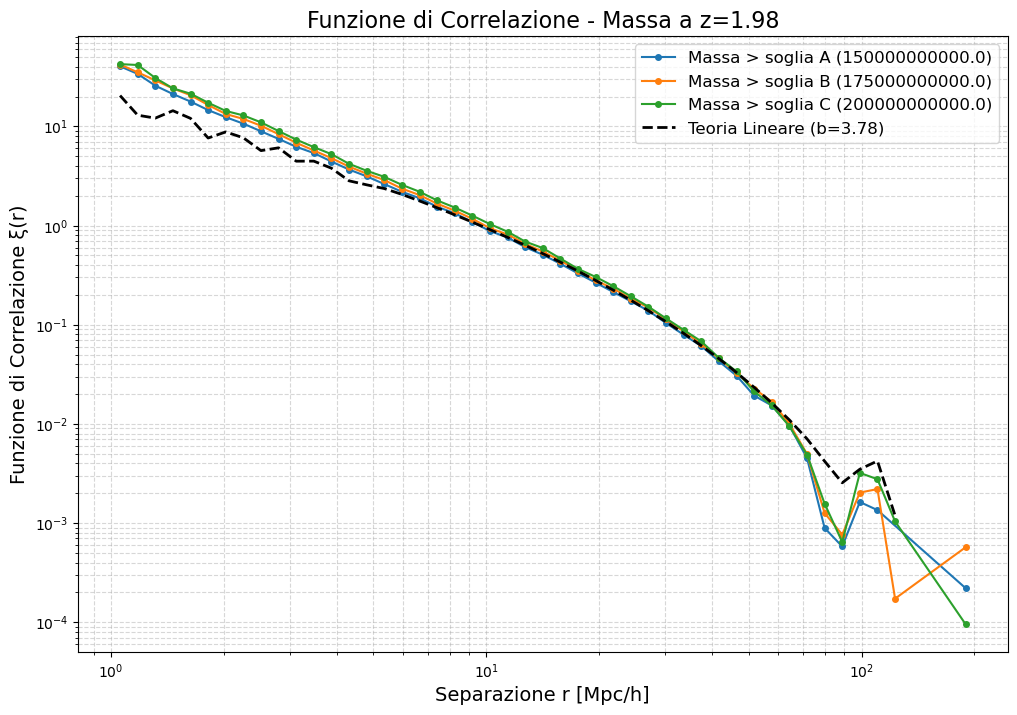

In [ ]:
#SEZIONE DI PLOT DEI RISULTATI

#Faccio un ciclo su tutti i file di input
for filename, file_results in results.items():
    #Estraggo il redshift dal nome del file e lo converto in float
    redshift_str = ''.join(filter(str.isdigit, filename.split('.')[0]))
    redshift_label = f"z={float(redshift_str)/100.0:.2f}" if redshift_str else filename

    #Setto il bias tra P(k) teorico e dati per questo file/redshift
    BIAS_FACTOR = bias_by_file.get(filename, 2.0)
    
    
    #Faccio un ciclo su ogni analisi per questo file
    for analysis_name, analysis_results in file_results.items():
        
        #Grafico Power Spectrum misurato e teorico
        #Creo una nuova figura e inizializzo flag e variabili
        plt.figure(figsize=(12, 8))
        plot_pk = False
        k_data_for_theory = None  

        #Faccio un ciclo sui risultati dell'analisi corrente
        for label, data in analysis_results.items():
            if not isinstance(data, dict):
                continue
            if (
                #Guardo se i dati contengono k e pk
                data.get('k') is not None and data.get('pk') is not None
                and isinstance(data['k'], np.ndarray) and isinstance(data['pk'], np.ndarray)
                and np.any((data['pk'] is not None) & (data['pk'] > 0))
            ):
                #Plotto P(k) in scala bilogaritmica
                plt.loglog(data['k'], data['pk'], 'o-', markersize=4, label=label)
                plot_pk = True
                #Salvo i k dei dati per l'interpolazione della curva teorica
                if k_data_for_theory is None:
                    k_data_for_theory = data['k']

        #Aggiungo la curva teorica SOLO sugli stessi k dei dati
        if plot_pk and 'theoretical_pk' in file_results and k_data_for_theory is not None:
            theoretical_data = file_results['theoretical_pk']
            #Interpolo P(k) teorico sui k dei dati e lo moltiplica per il bias^2
            pk_biased_theory_interp = np.interp(
                k_data_for_theory, theoretical_data['k'], theoretical_data['pk'] * (BIAS_FACTOR**2), left=np.nan, right=np.nan
            )
            #Plotto la curva teorica per P(k)
            plt.loglog(
                k_data_for_theory, pk_biased_theory_interp,
                color='k', ls='--', lw=2, label=f'Teoria Lineare (b={BIAS_FACTOR})'
            )
        
        #Aggiungo il titolo e la legenda
        if plot_pk:
            plt.xlabel("k [h/Mpc]", fontsize=14)
            plt.ylabel("P(k) [$(Mpc/h)^3$]", fontsize=14)
            plt.title(f"Spettro di Potenza - {analysis_name} a {redshift_label}", fontsize=16)
            plt.legend(fontsize=12)
            plt.grid(True, which="both", ls="--", alpha=0.5)
            plt.ylim(bottom=1e2)
            plt.show()

        #Grafico Funzione di Correlazione misurata e teorica
        #Creo una nuova figura e inizializzo flag e variabili
        plt.figure(figsize=(12, 8))
        plot_xi = False
        r_data_for_theory = None
        #Faccio un ciclo sui risultati dell'analisi corrente
        for label, data in analysis_results.items():
            if not isinstance(data, dict):
               continue
            if data.get('r') is not None and data.get('xi') is not None and np.any(data['xi'] > 0):
               #Plotto xi(r) in scala bilogaritmica
               plt.loglog(data['r'][data['xi'] > 0], data['xi'][data['xi'] > 0], 'o-', markersize=4, label=label)
            plot_xi = True
            #Salvo i r dei dati per l'interpolazione della curva teorica
            if r_data_for_theory is None:
             r_data_for_theory = data['r']
        
        #Aggiungo la curva teorica SOLO sugli stessi r dei dati
        if plot_xi and 'theoretical_xi' in file_results and r_data_for_theory is not None:
            theoretical_data = file_results['theoretical_xi']
            #Interpolo xi(r) teorico sui r dei dati
            r_theory, xi_theory = theoretical_data['r'], theoretical_data['xi']
            xi_theory_interp = np.interp(r_data_for_theory, r_theory, xi_theory, left=np.nan, right=np.nan)
            mask_theory = xi_theory_interp > 0
            if np.any(mask_theory):
                #Plotto la curva teorica per xi(r)
                plt.loglog(r_data_for_theory[mask_theory], xi_theory_interp[mask_theory],
                           color='k', ls='--', lw=2, label=f'Teoria Lineare (b={BIAS_FACTOR:.2f})')
        #Aggiungo il titolo e la legenda
        if plot_xi:
            plt.xlabel("Separazione r [Mpc/h]", fontsize=14); 
            plt.ylabel("Funzione di Correlazione ξ(r)", fontsize=14)
            plt.title(f"Funzione di Correlazione - {analysis_name} a {redshift_label}", fontsize=16)
            plt.legend(fontsize=12); plt.grid(True, which="both", ls="--", alpha=0.5); plt.show()



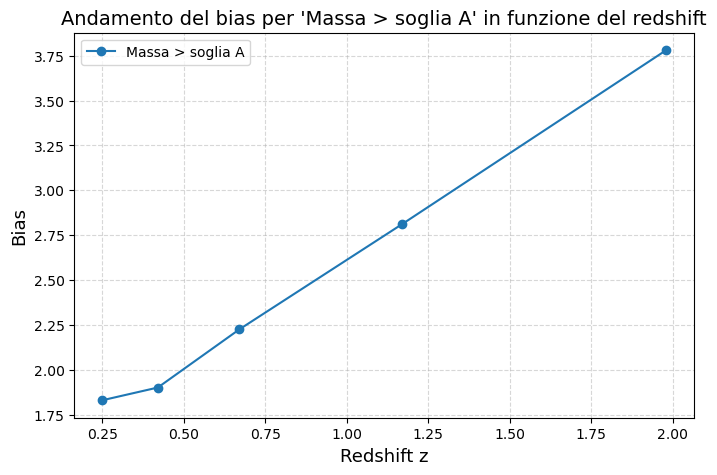

In [ ]:
#Grafico l'andamento del taglio in funzione del redshift

#Seleziono il taglio e l'analisi da fissare
fixed_cut = "Massa > soglia A"
fixed_analysis = "Massa"

# Creo una maschera per filtrare i dati in base al taglio e all'analisi selezionati
mask = bias_table['Cut'].str.contains(fixed_cut) & (bias_table['Analysis'] == fixed_analysis)
#Applico la maschera alla tabella e ordino i risultati per redshift
df_cut = bias_table[mask].sort_values('Redshift')

#Inserisco titolo e legenda
plt.figure(figsize=(8,5))
plt.plot(df_cut['Redshift'], df_cut['Bias'], 'o-', label=f"{fixed_cut}")
plt.xlabel("Redshift z", fontsize=13)
plt.ylabel("Bias", fontsize=13)
plt.title(f"Andamento del bias per '{fixed_cut}' in funzione del redshift", fontsize=14)
plt.grid(True, ls='--', alpha=0.5)
plt.legend()
plt.show()

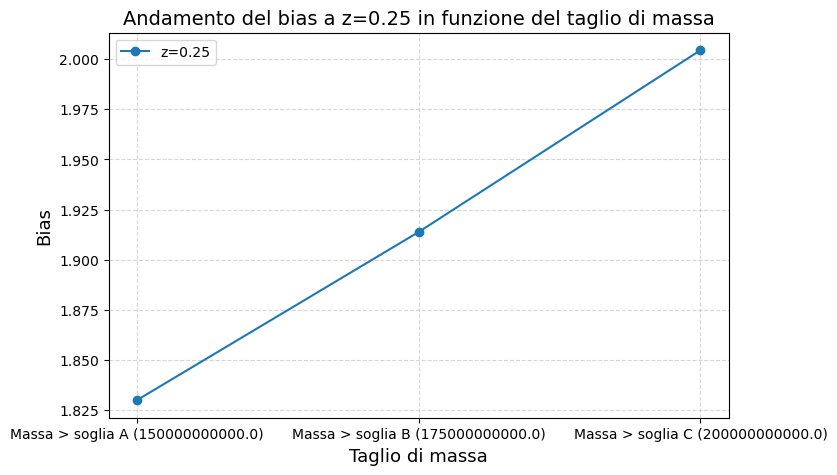

In [ ]:
#Grafico l'andamento del bias in funzione del taglio di massa per il redshift fissato

#Seleziono il file/redshift e l'analisi da fissare
fixed_file = "galaxy025.txt"
fixed_analysis = "Massa"

#Filtro la tabella per il file e l'analisi scelti
mask = (bias_table['File'] == fixed_file) & (bias_table['Analysis'] == fixed_analysis)
df_z = bias_table[mask].copy()

#Ordino i tagli in modo logico usando str.contains
cut_order = ["Massa > soglia A", "Massa > soglia B", "Massa > soglia C"]

# Trovo per ogni cut_order la riga corrispondente
ordered_rows = []
for cut in cut_order:
    row = df_z[df_z['Cut'].str.contains(cut)]
    if not row.empty:
        ordered_rows.append(row)

# Concateno le righe ordinate
if ordered_rows:
    df_z_ordered = pd.concat(ordered_rows)
else:
    df_z_ordered = pd.DataFrame()  # Vuoto se non trova nulla

#Inserisco titolo e legenda
plt.figure(figsize=(8,5))
plt.plot(df_z_ordered['Cut'], df_z_ordered['Bias'], 'o-', label=f"z={df_z_ordered['Redshift'].iloc[0]:.2f}")
plt.xlabel("Taglio di massa", fontsize=13)
plt.ylabel("Bias", fontsize=13)
plt.title(f"Andamento del bias a z={df_z_ordered['Redshift'].iloc[0]:.2f} in funzione del taglio di massa", fontsize=14)
plt.grid(True, ls='--', alpha=0.5)
plt.legend()
plt.show()